In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seml
import pandas as pd
import json
from collections import defaultdict, Counter
from functools import reduce
from itertools import product
import seaborn as sns
from scipy.stats import binned_statistic
from matplotlib.lines import Line2D

In [2]:
%cd ..

/nfs/homedirs/fuchsgru/MastersThesis


In [3]:
import data.constants as dc
import model.constants as mc

In [4]:
collection_name = 'week24_edge_reconstruction'
collection = seml.database.get_collection(collection_name)

In [5]:
by_status = defaultdict(set)
for r in collection.find():
    by_status[r['status']].add(r['config']['data']['dataset'])

In [6]:
by_status

defaultdict(set,
            {'COMPLETED': {'amazon_photo', 'citeseer', 'cora_full'},
             'RUNNING': {'amazon_photo'},
             'PENDING': {'amazon_photo'}})

In [7]:
experiments = [{'config' : r['config'], 'result' : r['result'], 'id' : r['_id']} for r in collection.find() if r['status'] in ('COMPLETED',)]
for ex in experiments:
    # print(ex['result'].keys())
    ex['metrics'] = ex['result']['results']

In [8]:
ex['config']['data']['ood_type']

'left-out-classes'

In [9]:
METRIC = 'Metric'
AUROC = 'AUC-ROC'
AUCPR = 'AUC-PR'

SETTING = 'Setting'
HYBRID = 'Inductive'
TRANSDUCTIVE = 'Transductive'
LOC = 'Leave Out Classes'
NORMAL = 'Normal'
BERNOULLI = 'Bernoulli'
NO_EDGES = 'No Edges'
PROXY = 'Proxy'
EXPERIMENT = 'Experiment'
DATASET = 'Dataset'
LOWER_LIPSCHITZ = 'Empirical Lower\nLipschitz Bound'
UPPER_LIPSCHITZ = 'Empirical Upper\nLipschitz Bound'
OOD_TYPE = 'OOD Experiment'
PERTRUBATIONS = 'Perturbations'


RECONSTRUCTION_TYPE = 'Edge Reconstruction'
RECONSTRUCTION_WEIGHT = 'Reconstruction Loss Weight'
AUTOENCODER = 'BCE'
ENERGY = 'Energy'
TRIPLET = 'Triplet'

EPISTEMIC = 'Epistemic'
ALEATORIC = 'Aleatoric'

ACCURACY = 'Accuracy'
# ECE = 'Expected Calibration Error'
ECE = 'ECE'

In [10]:
mode = 'test'

In [11]:
ex['config']['model']

{'activation': 'leaky_relu',
 'hidden_sizes': [64],
 'leaky_relu_slope': 0.01,
 'model_type': 'gcn',
 'reconstruction': {'loss_weight': 0.1, 'reconstruction_type': 'energy'},
 'use_bias': True}

In [12]:
# epistemic_proxy = 'ood_gpc-diag-mode:weighted-relative:False:no_fit-95conf'
aleatoric_proxy = 'ood_max-score'
epistemic_proxy = 'ood_gpc-diag-mode:weighted-relative:False:no_fit-mask'
# metric = 'auroc'
# METRIC = 'AUC-ROC'
metric = 'auroc'
METRIC = AUROC

In [13]:
# Get the model w/o any biases from the spectral-norm experiment
collection_name_sn = 'week22_lipschitz_son'
collection_sn = seml.database.get_collection(collection_name_sn)


In [14]:
experiments_sn = [{'config' : r['config'], 'result' : r['result'], 'id' : r['_id']} for r in collection_sn.find() if r['status'] in ('COMPLETED',)]
for ex in experiments_sn:
    # print(ex['result'].keys())
    ex['metrics'] = ex['result']['results']

In [15]:
print(f'Found {len(experiments_sn)} experiments for spectral norm')

Found 6262 experiments for spectral norm


In [16]:
experiments_sn[0]['config']['model']

{'activation': 'leaky_relu',
 'hidden_sizes': [64],
 'leaky_relu_slope': 0.01,
 'model_type': 'gcn',
 'residual': False,
 'use_bias': True,
 'use_spectral_norm': False,
 'use_spectral_norm_on_last_layer': False,
 'weight_scale': 1.0}

In [17]:
# only consider experiments without any bias

experiments_sn = [ex for ex in experiments_sn if (
    not ex['config']['model']['use_spectral_norm'] and not ex['config']['model']['residual']
)]
print(f'Kept {len(experiments_sn)} experiments of spectral norm without ind. biases')


Kept 108 experiments of spectral norm without ind. biases


In [18]:
data_proxy, data_acc_ece = [], []
unrecognized = set()

for ex in experiments + experiments_sn:
    cfg = ex['config']
    base = {
        SETTING : {dc.HYBRID : HYBRID, dc.TRANSDUCTIVE : TRANSDUCTIVE}[cfg['data']['setting']],
        DATASET :  cfg['data']['dataset'],
        LOWER_LIPSCHITZ : ex['metrics'][f'empirical_lipschitz_{mode}_slope_min_perturbation_noise_{mode}'][0]['value'],
        UPPER_LIPSCHITZ : ex['metrics'][f'empirical_lipschitz_{mode}_slope_max_perturbation_noise_{mode}'][0]['value'],
        OOD_TYPE : {dc.PERTURBATION : PERTRUBATIONS, dc.LEFT_OUT_CLASSES : LOC}[cfg['data']['ood_type']],
    }
    if 'reconstruction' in cfg['model']:
        base[RECONSTRUCTION_TYPE] = {
            mc.AUTOENCODER : AUTOENCODER, mc.TRIPLET : TRIPLET, mc.ENERGY : ENERGY,
        }[cfg['model']['reconstruction']['reconstruction_type']]
        base[RECONSTRUCTION_WEIGHT] = cfg['model']['reconstruction']['loss_weight']
    
    data_acc_ece.append(base | {
        ACCURACY : ex['metrics'][f'accuracy_{mode}_{mode}'][0],
        ECE : ex['metrics'][f'ece_{mode}_{mode}'][0]['value'],
    })
    for k, vs in ex['metrics'].items():
        if metric in k and k.endswith('_' + mode):
            k = k.replace(metric + '_', '').replace('_' + mode, '')
            if '-no-edges' in k:
                no_edges = True
                k = k.replace('-no-edges', '')
            else:
                no_edges = False
                
            if '_loc' in k or '-loc' in k:
                exp = LOC
                k = k.replace('_loc', '').replace('-loc', '')
            elif '_ber' in k or '-ber' in k:
                exp = BERNOULLI
                k = k.replace('_ber', '').replace('-ber', '')
            elif '_normal' in k or '-normal' in k:
                exp = NORMAL
                k = k.replace('_normal', '').replace('-normal', '')
            else:
                raise ValueError(k)
            
            metric_cfg = {}
            
            if k == aleatoric_proxy:
                metric_cfg[PROXY] = ALEATORIC
            elif k == epistemic_proxy:
                metric_cfg[PROXY] = EPISTEMIC
            else:
                unrecognized.add(k)
                continue
            
            for v in vs:
                v = v['value']
                data_proxy.append({
                    METRIC : v,
                    NO_EDGES : no_edges,
                    EXPERIMENT : exp,
                } | metric_cfg | base,
                )

In [19]:
df_proxy = pd.DataFrame(data_proxy)
df_acc_ece = pd.DataFrame(data_acc_ece)

In [20]:
df_proxy[df_proxy[RECONSTRUCTION_WEIGHT] == 1e-8]

,AUC-ROC,No Edges,Experiment,Proxy,Setting,Dataset,Empirical Lower\nLipschitz Bound,Empirical Upper\nLipschitz Bound,OOD Experiment,Edge Reconstruction,Reconstruction Loss Weight


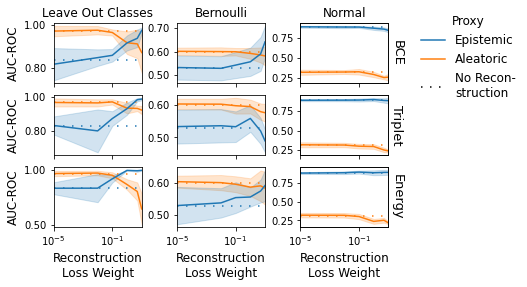

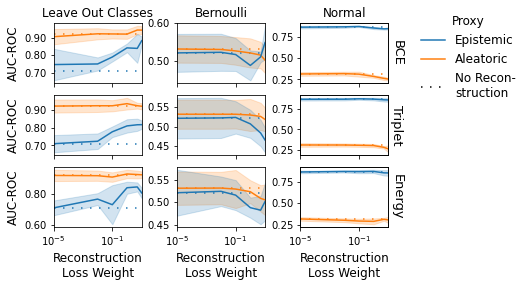

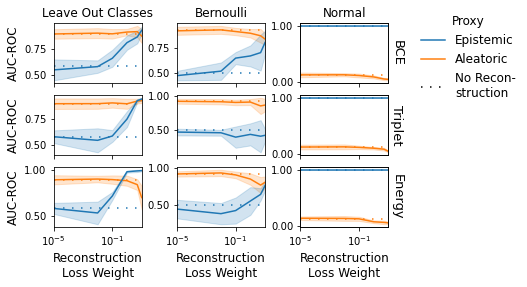

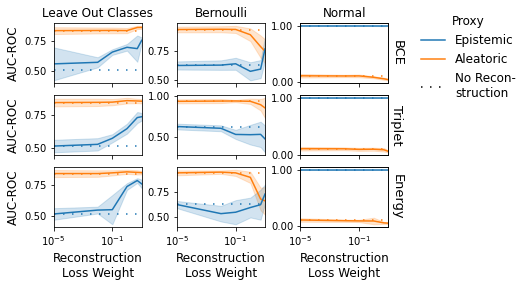

In [21]:
def facet_plot_experiment_reco_type_proxy_hue(df, x_name, y_name, x_label=None, sharex=True,
                                             no_edges_values=[False, True],
                                              settings=[TRANSDUCTIVE, HYBRID],
                                              datasets = [dc.CORA_FULL, dc.CITESEER, dc.AMAZON_PHOTO,],
                                             ):
    for no_edges, setting, dataset in product(no_edges_values, settings, datasets):
    # for no_edges, setting, dataset in product([False,], [HYBRID], [dc.CORA_FULL,]):
        if x_label is None:
            x_label = x_name
        
        fig, axs = plt.subplots(3, 3, figsize=(6, 5 * 0.75), sharex=sharex, sharey=False, 
                                gridspec_kw = {
                                 'wspace' : 0.4,
                                }
                               )

        ls_base = (0, (1, 5)) # The linestyle for the baseline

        for col_idx, experiment in enumerate((LOC, BERNOULLI, NORMAL)):
            df_exp = df[
                    (df[SETTING] == setting) & (df[NO_EDGES] == no_edges) & (df[DATASET] == dataset) &
                    (df[EXPERIMENT] == experiment)
                ]
            y_alea = df_exp[(df_exp[PROXY] == ALEATORIC) & ~np.isfinite(df_exp[x_name])][y_name]
            y_epi = df_exp[(df_exp[PROXY] == EPISTEMIC) & ~np.isfinite(df_exp[x_name])][y_name]


            for row_idx, reco_type in enumerate((AUTOENCODER, TRIPLET, ENERGY)):
                ax = axs[row_idx, col_idx]

                df_reco_type = df_exp[df_exp[RECONSTRUCTION_TYPE] == reco_type]
                # print(df_reco_type.shape, no_edges, setting, dataset)

                x_lim = (df_reco_type[x_name].min(), df_reco_type[x_name].max())
                ax.set_xlim(x_lim)
                ax.set_xscale('log')

                ax.plot(x_lim, [y_alea.mean(), y_alea.mean()], color='tab:orange', ls=ls_base)
                ax.plot(x_lim, [y_epi.mean(), y_epi.mean()], color='tab:blue', ls=ls_base)

                # Bin statistics by reco weight and group by alea, epi
                xs, means, stds = (defaultdict(list) for _ in range(3))
                for proxy in (ALEATORIC, EPISTEMIC):
                    _df = df_reco_type[(df_reco_type[PROXY] == proxy)]
                    for x in sorted(np.unique(_df[x_name])):
                        means[proxy].append(_df[_df[x_name] == x][y_name].mean())
                        stds[proxy].append(_df[_df[x_name] == x][y_name].std())
                        xs[proxy].append(x)
                xs, means, stds = ({k : np.array(v) for k, v in arr.items()} for arr in (xs, means, stds))


                ax.plot(xs[ALEATORIC], means[ALEATORIC], color='tab:orange', ls='-')
                ax.fill_between(xs[ALEATORIC], means[ALEATORIC] - stds[ALEATORIC], means[ALEATORIC] + stds[ALEATORIC], alpha = 0.2, color='tab:orange')

                ax.plot(xs[EPISTEMIC], means[EPISTEMIC], color='tab:blue', ls='-')
                ax.fill_between(xs[EPISTEMIC], means[EPISTEMIC] - stds[EPISTEMIC], means[EPISTEMIC] + stds[EPISTEMIC], alpha = 0.2, color='tab:blue')

                from matplotlib.ticker import FormatStrFormatter
                ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

            axs[0, col_idx].set_title(experiment)
            axs[-1, col_idx].set_xlabel(x_label, fontsize=12)

        for ax in axs[:, 0].flatten():
            ax.set_ylabel(y_name, fontsize=12)

        for row_idx, reco_type in enumerate((AUTOENCODER, TRIPLET, ENERGY)): 
            ax2 = axs[row_idx, -1].twinx()
            ax2.set_ylabel(reco_type, fontsize=13, rotation=270, labelpad=15)
            ax2.set_yticks([])

        handles = []
        handles += axs[-1, -1].plot([], [], color='tab:blue', label=EPISTEMIC, linestyle='-')
        handles += axs[-1, -1].plot([], [], color='tab:orange', label=ALEATORIC, linestyle='-')
        handles += axs[-1, -1].plot([], [], color='black', label='No Reconstruction', linestyle=ls_base)

        legend = fig.legend(handles, [EPISTEMIC, ALEATORIC, 'No Recon-\nstruction'], title='Proxy', loc='upper right', 
                            bbox_to_anchor=(1.22, 0.95), frameon=False, fontsize=12)
        plt.setp(legend.get_title(),fontsize=12)
        x_name_save, y_name_save = (name.lower().replace(' ', '-') for name in (x_name, y_name))
        fig.savefig(f'thesis_nbs/edge_reconstruction_plots/{x_name_save}-{y_name_save}-{dataset}-{setting}-remove-edges-{no_edges}.pdf', bbox_inches='tight')
        
    
facet_plot_experiment_reco_type_proxy_hue(df_proxy, RECONSTRUCTION_WEIGHT, METRIC, 
                                          x_label='Reconstruction\nLoss Weight', sharex=True,
                                         datasets=[dc.CORA_FULL])

ValueError: Axis limits cannot be NaN or Inf

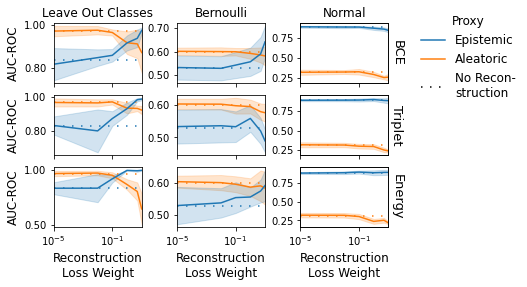

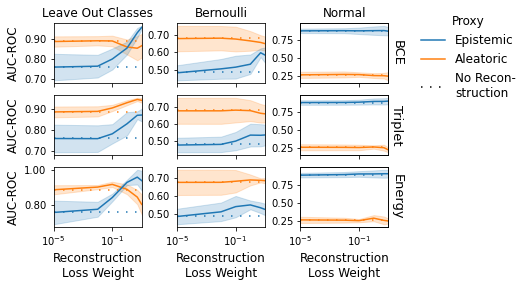

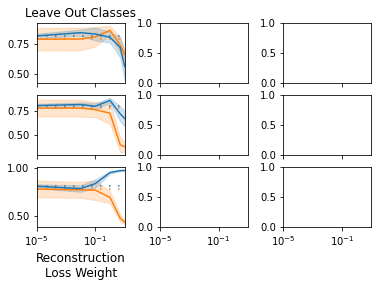

In [22]:
facet_plot_experiment_reco_type_proxy_hue(df_proxy, RECONSTRUCTION_WEIGHT, METRIC, 
                                          x_label='Reconstruction\nLoss Weight', sharex=True)

In [27]:
from collections.abc import Iterable

def plot_non_proxy_metrics(df, x_name, y_metrics=[ACCURACY, ECE, LOWER_LIPSCHITZ], y_log_scales=False, datasets=[dc.CORA_FULL, dc.CITESEER, dc.AMAZON_PHOTO], x_label=None):

    if x_label is None:
        x_label = x_name
        
    if not isinstance(y_log_scales, Iterable):
        y_log_scales = [y_log_scales for _ in y_metrics]
    
    #for setting, dataset in ((TRANSDUCTIVE, dc.CORA_FULL),):
    for setting, dataset in product((TRANSDUCTIVE, HYBRID), datasets):

        fig, axs = plt.subplots(len(y_metrics), 2, figsize=(6, 5 * 0.75), sharex=True, sharey=False, 
                                        gridspec_kw = {
                                         'wspace' : 0.3,
                                    }
                                   )

        ls_base = (0, (1, 5))

        hue_to_color = {
            AUTOENCODER : 'tab:blue',
            TRIPLET : 'tab:orange',
            ENERGY : 'tab:green',
        }

        for col_idx, experiment in enumerate((LOC, PERTRUBATIONS)):
            df_exp = df[
                    (df[SETTING] == setting) & (df[DATASET] == dataset) &
                    (df[OOD_TYPE] == experiment)
                ]

            for row_idx, (metric, y_log_scale) in enumerate(zip(y_metrics, y_log_scales)):
                ax = axs[row_idx, col_idx]


                # Plot the baseline value
                y_base = df_exp[~np.isfinite(df_exp[x_name])][metric]
                x_lim = (df_exp[x_name].min(), df_exp[x_name].max())
                ax.set_xlim(x_lim)
                ax.set_xscale('log')
                ax.plot(x_lim, [y_base.mean(), y_base.mean()], color='black', ls=ls_base)

                for hue, color in hue_to_color.items():

                    df_hue = df_exp[(df_exp[RECONSTRUCTION_TYPE] == hue)]


                    # Plot the model value
                    # Bin statistics by reco weight
                    xs, means, stds = ([] for _ in range(3))
                    _df = df_hue
                    for x in sorted(np.unique(_df[x_name])):
                        means.append(_df[_df[x_name] == x][metric].mean())
                        stds.append(_df[_df[x_name] == x][metric].std())
                        xs.append(x)
                    xs, means, stds = (np.array(arr) for arr in (xs, means, stds))

                    ax.plot(xs, means, color=color, ls='-')
                    ax.fill_between(xs, means - stds, means + stds, alpha = 0.2, color=color)

                    from matplotlib.ticker import FormatStrFormatter
                    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
                    
                if y_log_scale:
                    ax.set_yscale('log')

            axs[0, col_idx].set_title(experiment)
            axs[-1, col_idx].set_xlabel(x_label, fontsize=12)

        for y_name, ax in zip(y_metrics, axs[:, 0].flatten()):
            ax.set_ylabel(y_name, fontsize=12)

        handles = []
        hue_names = []
        for hue, color in hue_to_color.items():
            handles += axs[-1, -1].plot([], [], color=color, label=hue, linestyle='-')
            hue_names.append(hue)
        handles += axs[-1, -1].plot([], [], color='black', label='No Reconstruction', linestyle=ls_base)
        hue_names.append('No Recon-\nstruction')
        legend = fig.legend(handles, hue_names, title=RECONSTRUCTION_TYPE, loc='upper right', 
                            bbox_to_anchor=(1.24, 0.95), frameon=False, fontsize=12)
        plt.setp(legend.get_title(),fontsize=12)
        x_name_save = x_name.lower().replace(' ', '-')
        fig.savefig(f'thesis_nbs/edge_reconstruction_plots/{x_name_save}-{dataset}-{setting}-no-proxy-metrics.pdf', bbox_inches='tight')

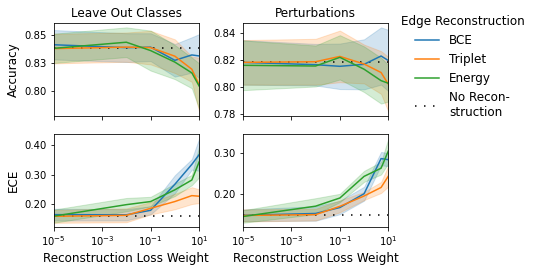

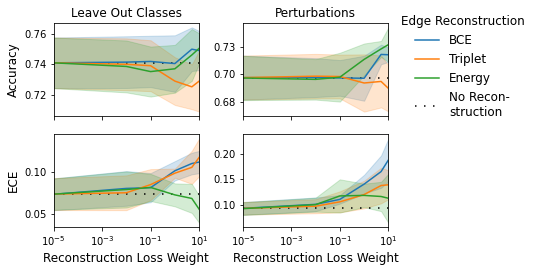

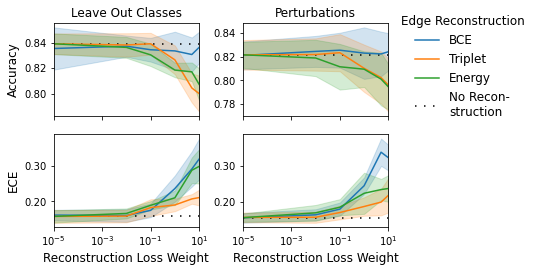

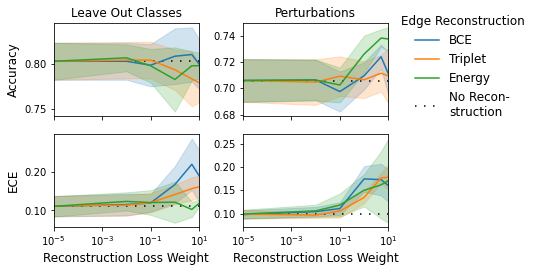

In [30]:
plot_non_proxy_metrics(df_acc_ece, RECONSTRUCTION_WEIGHT, y_metrics=[ACCURACY, ECE], datasets=[dc.CORA_FULL, dc.CITESEER])